# 0. Setup

In [3]:
# TO REMOVE
! pip install transformers newspaper3k datasets urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 211 kB 58.4 MB/s 
     |████████████████████████████████| 452 kB 67.0 MB/s 
     |████████████████████████████████| 127 kB 60.6 MB/s 
     |████████████████████████████████| 182 kB 61.0 MB/s 
     |████████████████████████████████| 7.6 MB 44.5 MB/s 
     |████████████████████████████████| 93 kB 2.6 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 7.4 MB 51.6 MB/s 
     |████████████████████████████████| 132 kB 47.0 MB/s 
     |████████████████████████████████| 213 kB 72.8 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=6dd8ff60f966061815eb8ed0c103084062dff7fd32901a50aee8a6e5c9c73842
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09

In [4]:
import urllib3
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Union, Any
from tqdm import tqdm
import newspaper
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import datasets
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from datasets import load_dataset
import transformers
from transformers import pipeline
from transformers import TFAutoModel 
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
import spacy

In [7]:
# TO REMOVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 0.1 Defining variables

In [92]:
URL = 'url'
TEXT = 'text'
LEMMATIZED = 'cleaned_lemmatized_text'
TARGET = 'label'

MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'

html_folder = HTML_FOLDER # is it being used or I can delete it?

nlp = spacy.load('en_core_web_sm')

DISTILBERT_MAX_INPUT = 510 # 512 - the [CLS] and [SEP] tokens

labels_encoded = {'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}
labels_decoded = {y: x for x, y in labels_encoded.items()}

maximum_classes = len(labels_encoded)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [9]:
os.chdir(MAIN_FOLDER)

# 0.2 Functions

## Saving/loading variables

In [85]:
def save_variables(variables: Dict[str, Any]) -> None:
  """
  Saves variables to disk using pickle.
  
  @variables: dictionary where the keys are the names to use when saving the variables, and the values are the variables to be saved.
  
  Returns:
  None
  """

  for variable_name, variable in variables.items():
    with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
      pickle.dump(variable, f)


def read_variable(variable_name):
  """
  Loads a variable previously saved in disk using pickle.

  @variable_name: path of the variable saved

  Returns:
  - variable: the loaded variable
  """

  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

## Preprocessing

In [86]:
def read_csv(csv_path: str, usecols: List[str] = None, namecols: List[str] = None, remove_nan: str = None, ignore_dash: bool = False) -> pd.DataFrame:
  """
  Create a DataFrame from a CSV file.

  @csv_path: the path to the CSV file.
  @usecols: a list of column names to use from the CSV file. If not provided, all columns will be used.
  @namecols: a list of new names for the columns from the CSV file. If not provided, the original column names will be used.
  @remove_nan: the name of the column from where rows with missing values will be removed. It must be from namecols (or from usecols, if namecols was not provided). If not provided, all rows will be kept.
  @ignore_dash: a flag indicating whether to ignore rows with a dash (`-`) in the target column. If not provided, rows with a dash in the target column will be included in the data.

  Returns: 
  - df: a pandas DataFrame object.
  """

  df = pd.read_csv(csv_path, usecols=usecols)

  if namecols:
    assert len(usecols) == len(namecols)
    rename_columns = {usecols[i]: namecols[i] for i in range(len(usecols))}
    df.rename(columns=rename_columns, inplace=True)
  
  if remove_nan:
    df = df[~df[remove_nan].isna()]

  if ignore_dash:
    df = df[df['label'] != '-']
  
  df.loc[df[TARGET] == 'MISC/Blog?', TARGET] = 'MISC' # all sections of blogs labeled as 'MISC/Blog?' become part of 'MISC'.

  df.reset_index(drop=True, inplace=True)

  return df


def read_htmls(df: pd.DataFrame, column: str) -> List[str]:
  """
  Read HTML files from a pandas DataFrame.

  @df: a DataFrame with a column containing the names of the HTML files.
  @column: the name of the column in the DataFrame where the filenames are stored.

  Returns: 
  - htmls: a list of strings, one for each HTML file.
  """

  filenames = df[column].values
  htmls = list()

  for i, filename in enumerate(tqdm(filenames)):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls


def read_articles(htmls: List[str]) -> List[newspaper.article.Article]:
  """
  Read articles from a list of HTML strings.
  
  @htmls: a list of HTML strings representing articles.
  
  Returns: 
  - toi_articles: a list of newspaper.article.Article objects, one for each HTML string.
  """
  
  toi_articles = list()

  for html in tqdm(htmls):
    toi_article = Article(url = ' ', language = 'en')
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  return toi_articles


def create_df_from_articles(df: pd.DataFrame, toi_articles: List[newspaper.article.Article]) -> pd.DataFrame:
  """
  Create a DataFrame with article text and labels from a list of articles.
  
  @df: a DataFrame with a TARGET column containing the labels for the articles.
  @toi_articles: a list of newspaper.article.Article objects.
  
  Returns: a DataFrame with two columns: TEXT, containing the concatenated title and text of the articles, and TARGET, containing the labels for the articles.
  """

  summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]
  y = df[TARGET].tolist()
  assert len(y) == len(summaries)

  df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

  return df_text1

In [87]:
def read_or_create_variables(variable_names: List[str]) -> List[Any]:
  """
  Read or create variables with the given names. If a variable exists, it is read and returned. 
  If a variable with a given name does not exist, it is created and an empty list is returned.
  
  @variable_names: list of strings representing the names of the variables to be read and/or created.
  
  Returns:
  - variables: list of the read and/or created variables.
  """

  variables = list()

  for variable_name in variable_names:
    try:
      variable = read_variable(variable_name)
      print(f'SUCCESS: variable {variable_name} was read, it contains {len(variable)} elements.')
    except FileNotFoundError:
      variable = list()
      print(f'Variable {variable_name} was just created and contains {len(variable)} elements.')

    variables.append(variable)

  return variables


def create_new_urls(df: pd.DataFrame, column: str) -> pd.Series:
  """
  Creates the urls to read based on the difference between all URLs and the ones already read.

  @df (pd.DataFrame): a DataFrame with a column containing the URLs.
  @column (str): the name of the column in the DataFrame where the URLs are stored.

  Returns:
  - urls_new: pandas Series object with strings of the URLs to read.
  """

  urls = df[column]
  mask = np.isin(urls, urls_old)
  urls_new = urls[~mask]
  print(f'There are {len(urls_new)} new URLs to read.')

  return urls_new


def read_texts_from_urls(urls_new: pd.Series, urls_old: List[str]) -> Tuple[List[str], List[int], List[int]]:
  """
  Reads the relevant text from each URL.

  @urls_new: pandas Series object with strings of the URLs to read.
  @urls_old: list of strings of the URLs that have already been read.
  
  Returns a tuple of three elements:
  - texts_new: list of strings of the texts read from the URLs.
  - indexes_new: list of integers representing the indexes of the URLs that were read successfully.
  - idx_label_to_remove: list of integers representing the indexes, starting from 0, that threw errors and should be deleted.
  """

  texts_new = list()
  indexes_new = list()

  idx_label_to_remove = list()
  idx_label = 0

  for i, url in enumerate(urls_new, len(urls_old)):
    try:
      toi_article = Article(url=url, language='en')
      toi_article.download()
      toi_article.parse()
      toi_article.nlp()
      text = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
      texts_new.append(text)
      indexes_new.append(i)
      print(f'{i}: url "{url}" read successfully.')
    except Exception:
      idx_label_to_remove.append(idx_label)
      print(f'{i}: ERROR: url "{url}" was not read successfully.')
    
    idx_label += 1
  
  if idx_label_to_remove:
    print(f'\nWhen reading the new URLs, {len(urls_new) - len(indexes_new)} of them threw an error and could not be read.')
  elif texts_new:
    print('All URLs were successfully read.')
  else:
    print('No new URL was read.')

  return texts_new, indexes_new, idx_label_to_remove


def create_new_labels(df: pd.DataFrame, urls_to_read: pd.Series, idx_label_to_remove: List[int]) -> List[str]:
  """
  Creates a list of labels for the given URLs and removes the labels corresponding to the URLs that threw errors.
  
  @df: pandas DataFrame containing the labels.
  @urls_to_read: pandas Series object with strings of the URLs for which the labels should be created.
  @idx_label_to_remove: list of integers representing the indexes of the URLs that threw errors and should have their labels removed.
  
  Returns:
  - labels_new: list of labels according to the new URLs, discarding the ones that threw errors.
  """
  
  labels_new = df.loc[urls_to_read.index, TARGET]
  assert (labels_new == df.loc[labels_new.index, TARGET]).all()
  labels_new.reset_index(drop=True, inplace=True)
  labels_new = labels_new.drop(idx_label_to_remove).tolist()

  return labels_new


def update_variables(old_variables: List[Any], new_variables: List[Any]) -> List[Any]:
  """
  Updates the old variables with the new variables.
  
  @old_variables: list of variables that should be updated.
  @new_variables: list of variables used to update the old variables, should be of same length and order as `old_variables`.
  
  Returns:
  - updated_variables: list of variables that are the result of updating the old variables with the new variables.
  """

  assert len(old_variables) == len(new_variables)

  updated_variables = list()
  zipped_variables = list(zip(old_variables, new_variables))

  for old_var, new_var in zipped_variables:
    updated_variable = old_var + new_var
    updated_variables.append(updated_variable)

  return updated_variables


def create_df_from_lists(labels: List[str], indexes: List[int], texts: List[str], urls: List[str]) -> pd.DataFrame:
  """
  Creates a pandas DataFrame with columns for URLs, texts, and labels.
  
  @labels: list of strings representing the labels of the articles.
  @indexes: list of integers representing the indexes of the articles.
  @texts: list of strings representing the texts of the articles.
  @urls: list of strings representing the URLs of the articles.
  
  Returns:
  - df_text2: pandas DataFrame with columns for URLs, texts, and labels.
  """

  df_text2 = pd.DataFrame({
      URL: pd.Series(urls).loc[indexes],
      TEXT: texts,
      TARGET: labels,
      }).reset_index(drop=True)

  return df_text2

In [ ]:
def remove_duplicates(df: pd.DataFrame, column: str) -> pd.DataFrame:
  """
  Remove duplicate rows from a DataFrame based on a specific column.
  
  Parameters:
  - df: a DataFrame with a column containing values to be checked for duplicates.
  - column: the name of the column in the DataFrame where the values are stored.
  
  Returns:
  - df: DataFrame with duplicate rows removed. If there were no duplicates, the original DataFrame is returned.
  """

  if df[column].duplicated().any():
    original_amount = df.shape[0]
    df = df[~df[column].duplicated()]
    print(f"{original_amount - df.shape[0]} rows had duplicate values in the dataframe's column '{column}' and were deleted.")
    assert not df[column].duplicated().any()

  else:
    print(f"There are no duplicate values in the dataframe's column '{column}'.")
  
  return df


def remove_rows(df: pd.DataFrame, with_errors: bool = False, irrelevant: bool = False, below_threshold: int = None) -> pd.DataFrame:
  """
  Removes rows from a pandas DataFrame that meet certain conditions.
  
  Parameters:
  - df: pandas DataFrame from which rows should be removed.
  - with_errors: boolean flag indicating whether rows with URLs' texts that throw errors should be removed. If set to True, rows with texts that have less than 100 words and contain both the strings " 404 " and " error " will be removed.
  - irrelevant: boolean flag indicating whether rows with irrelevant labels should be removed. If set to True, rows with labels that are not included in the dictionary `labels_encoded` will be removed.
  - below_threshold: integer representing the minimum number of words that the text of a URL must contain for it to be included in the final DataFrame. Rows with texts containing fewer words than this threshold will be removed.

  Returns:
  - df: pandas DataFrame with rows that met a condition removed.
  """

  if with_errors:
    words = df[TEXT].str.split().str.len()
    condition1 = words < 100 # empirical threshold
    condition2 = df[TEXT].str.contains(' 404 ')
    condition3 = df[TEXT].str.contains(' error ')
    df = df[~(condition1 & condition2 & condition3)]

  if irrelevant:
    df = df[df[TARGET].isin(labels_encoded)]
    df.reset_index(drop=True, inplace=True)

  # If the words that the text a URL contains is below this threshold, the row is discarded
  if below_threshold:
    words = df[TEXT].str.split().str.len()
    df = df[words >= below_threshold]

  return df


def text_preprocessing(text: str, lemmatize: bool = False, clean: bool = False) -> str:
  """
  Preprocess text by applying lemmatization and cleaning operations.
  
  Parameters:
  - text: a string of the text to be preprocessed.
  - lemmatize: a flag indicating whether to apply lemmatization to the text. Default is False.
  - clean: a flag indicating whether to clean the text. Default is False.
  
  Returns:
  - text: a string of the preprocessed text.
  """

  if lemmatize:
    text = ' '.join(token.lemma_ for token in nlp(text))
  
  if clean:
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

  return text

In [ ]:
def split_data(df: pd.DataFrame, column: str, test_size: float = 0.2, val_size: float = None, random_state: int = None) -> Union[Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series], Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]]:
  """
  Splits a pandas DataFrame into training, validation (if needed), and test sets.
  Data is split in a stratified fashion according to `df[TARGET]`.
  
  Parameters:
  - df: pandas DataFrame containing the data to be split.
  - column: name of the column in the DataFrame to be used as the input data (X).
  - test_size: float representing the proportion of the whole data to be used for the test set. Must be between 0.0 and 1.0.
  - val_size: float representing the proportion of the whole data to be used for the validation set. Must be between 0.0 and 1.0.
  - random_state: integer seed for the random number generator.
  
  Returns:
  - X_train: pandas DataFrame containing the input data for the training set.
  - (if `val_size` is provided) X_val: pandas DataFrame containing the input data for the validation set.
  - X_test: pandas DataFrame containing the input data for the test set.
  - y_train: pandas Series containing the target data for the training set.
  - (if `val_size` is provided) y_val: pandas Series containing the target data for the validation set.
  - y_test: pandas Series containing the target data for the test set.
  """

  X = df[[column]]
  y = df[TARGET]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      stratify=y, 
                                                      random_state=random_state
                                                      )
  
  if val_size:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=1/((1-test_size)/val_size),
                                                      stratify=y_train, 
                                                      random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

  return X_train, X_test, y_train, y_test


def vectorize_data(column: str, X_train: pd.DataFrame, X_test: pd.DataFrame, X_val: pd.DataFrame = None, ngram_range: Tuple[int, int] = (1, 1)) -> Union[Tuple[pd.DataFrame, pd.DataFrame], Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
  """
  Vectorizes the data in a pandas DataFrame column using the TfidfVectorizer.
  
  Parameters:
  - column: name of the column in the DataFrame to be vectorized.
  - X_train: pandas DataFrame containing the input data for the training set.
  - X_test: pandas DataFrame containing the input data for the test set.
  - X_val: (optional) pandas DataFrame containing the input data for the validation set.
  - ngram_range: tuple of integers specifying the lower and upper boundaries of the range of n-values for different n-grams to be extracted.
  
  Returns:
  - X_train: pandas DataFrame containing the vectorized input data for the training set.
  - X_test: pandas DataFrame containing the vectorized input data for the test set.
  - (if `X_val` is provided) X_val: pandas DataFrame containing the vectorized input data for the validation set.
  """

  vectorizer = TfidfVectorizer(ngram_range=ngram_range)
  X_train_tr = vectorizer.fit_transform(X_train[column])
  X_test_tr = vectorizer.transform(X_test[column])

  if X_val:
    X_val_tr = vectorizer.transform(X_val[column])

    return X_train_tr, X_val_tr, X_test_tr

  return X_train_tr, X_test_tr

## Modeling

In [88]:
def fit_model(clf, X_train, y_train):
  clf.fit(X_train, y_train)
  return clf


def predict(clf, X_test):
  y_pred = clf.predict(X_test)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def create_misclassified_df(X_test, y_test, y_pred):
  if type(y_pred) == np.ndarray and type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  mask = y_pred != y_test
  
  if type(y_pred) == np.ndarray and type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 
  return df
  

## EDA (not needed in the .py file):

In [89]:
def check_if_exists(variable_name):
  """
  Checks if a variable exists in the global scope.

  @variable_name: name of the variable

  Returns:
  None
  """
  
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')


def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)


def print_important_features(clf, vectorizer, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_decoded[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy



def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')


def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')


def print_confusion_matrix(y_test, y_pred, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  y_test = list(map(lambda x: labels_decoded[x], y_test))
  y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))

# 0.3 (Optional) Load "df_text1"

In [13]:
VARIABLE = 'df_text1'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text1 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text1" does not exist.
Reading variable "df_text1"...
Variable "df_text1" exists.


In [14]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load "df_text2"

In [15]:
VARIABLE = 'df_text2'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text2 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text2" does not exist.
Reading variable "df_text2"...
Variable "df_text2" exists.


In [16]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


# 0.5 (Optional) Load "df_text"

In [17]:
VARIABLE = 'df_text'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text" does not exist.
Reading variable "df_text"...
Variable "df_text" exists.


In [18]:
df_text

,text,label,url,cleaned_lemmatized_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,Blog,NaN,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,Article,NaN,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,Article,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,Article,http://www.outsourcing-pharma.com/Article/2021...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,Article,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,Article,http://www.koreabiomed.com/news/articleView.ht...,Medidata Acorn AI solution raise clinical tria...


# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [93]:
df1 = read_csv('activities_unlabeled.csv', 
               usecols=['File Name', 'Label'], 
               namecols=['filename', 'label'], 
               remove_nan='filename', 
               ignore_dash=True)

htmls = read_htmls(df1, 'filename')

toi_articles = read_articles(htmls)

df_text1 = create_df_from_articles(df1, toi_articles)

100%|██████████| 461/461 [01:32<00:00,  4.99it/s]


In [94]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [95]:
save_variables(variables={'df_text1': df_text1})

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [96]:
df2 = read_csv('activities_labeled13.csv', 
               usecols=['url', 'true_label'], 
               namecols=['url', 'label'], 
               remove_nan='label')

labels_old, indexes_old, texts_old, urls_old = read_or_create_variables(['labels_old', 'indexes_old', 'texts_old', 'urls_old'])

urls_new = create_new_urls(df2, 'url')

texts_new, indexes_new, idx_label_to_remove = read_texts_from_urls(urls_new, urls_old)

labels_new = create_new_labels(df2, urls_new, idx_label_to_remove)

labels, indexes, texts, urls = update_variables(old_variables=[labels_old, indexes_old, texts_old, urls_old],
                                                new_variables=[labels_new, indexes_new, texts_new, urls_new.tolist()])

assert len(texts) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)

df_text2 = create_df_from_lists(labels, indexes, texts, urls)

SUCCESS: variable labels_old was read, it contains 1019 elements.
SUCCESS: variable indexes_old was read, it contains 1019 elements.
SUCCESS: variable texts_old was read, it contains 1019 elements.
SUCCESS: variable urls_old was read, it contains 1246 elements.
There are 0 new URLs to read.
No new URL was read.


In [97]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


In [98]:
save_variables(variables={'labels_old': labels,
                          'indexes_old': indexes,
                          'texts_old': texts,
                          'urls_old': urls,
                          'df_text2': df_text2})

# 0.8 (Optional) Create and save "df_text"

In [105]:
df_text2 = remove_duplicates(df_text2, URL)

df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)

df_text = remove_duplicates(df_text, TEXT)

df_text = remove_rows(df_text, with_errors=True, irrelevant=True, below_threshold=51)

df_text[LEMMATIZED] = df_text[TEXT].apply(lambda x: text_preprocessing(x, lemmatize=True, clean=True))

There are no duplicate values in the dataframe's column 'url'.
59 rows had duplicate values in the dataframe's column 'text' and were deleted.


In [103]:
df_text

,text,label,url,cleaned_lemmatized_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,Blog,NaN,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,Article,NaN,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,Article,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,Article,http://www.outsourcing-pharma.com/Article/2021...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,Article,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,Article,http://www.koreabiomed.com/news/articleView.ht...,Medidata Acorn AI solution raise clinical tria...


In [104]:
save_variables({'df_text': df_text})

# 0.9 Further EDA and preprocessing on "df_text" (all not to be included in the .py file)

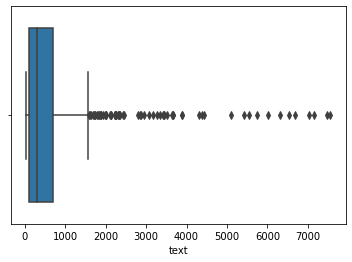

In [ ]:
# To play with:

# THRESHOLD1 = 50
# THRESHOLD2 = 51

# characters = df_text[TEXT].str.split().str.len()
# df_text.loc[(characters >= THRESHOLD1) & (characters <= THRESHOLD2), TEXT].tolist()

In [ ]:
# By analizing the texts, errors started to show up in the ones that had below 51 words.

fraction_ignored = 0.165 # We will lose 16.5% of our data

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(fraction_ignored)
minimum_words

72.0

In [ ]:
values.describe()[['25%', '75%']]

25%    110.5
75%    697.5
Name: text, dtype: float64

In [ ]:
mask = df_text[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT
print(f'There are {mask.sum()} texts ({mask.sum() / df_text.shape[0]:.0%} of the total) that will be truncated by DistilBERT '
      f'for having more than {DISTILBERT_MAX_INPUT} words.')

In [ ]:
plt.hist(df_text[TEXT].str.split().str.len(), bins=16)
plt.show()

In [ ]:
# df_text.loc[df_text[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT, TEXT].str.split().str.len()

In [ ]:
def clean_text(text):
    """
    @text: a string
    Returns a cleaned version of the provided string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replaces REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # deletes symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # deletes stopwords from text
    return text

In [ ]:
def lemmatize_text(text):
    """
    @text: a string
    Returns a lemmatized version of the provided string
    """
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

In [ ]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

# 1. BoW approach

## Preprocessing

In [ ]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

X_train, X_test, y_train, y_test = split_data(df_text, LEMMATIZED, test_size=0.2, random_state=0)

X_train_tr, X_test_tr = vectorize_data(LEMMATIZED, X_train, X_test, ngram_range=(1, 1))

In [ ]:
# NOT INCLUDE IN .py FILE AND DELETE THIS SENTENCE FROM HERE WHEN I'M DONE.
# Making sure the split was stratified correctly.
train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)
assert (np.isclose(train_distribution, test_distribution, rtol=1e-01)).all()

# NOT INCLUDE IN .py FILE AND DELETE THIS SENTENCE FROM HERE WHEN I'M DONE.
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy when predicting always the majority class: {baseline_accuracy:.4f}')

# NOT INCLUDE IN .py FILE AND DELETE THIS SENTENCE FROM HERE WHEN I'M DONE.
get_most_common_tokens(df=X_train, column='cleaned_lemmatized_text', amount=10)

Baseline accuracy when predicting always the majority class: 0.2326


[('use', 1690),
 ('patient', 1572),
 ('clinical', 1394),
 ('trial', 1351),
 ('datum', 1345),
 ('company', 1241),
 ('I', 1232),
 ('make', 1187),
 ('content', 1174),
 ('post', 1077)]

## Modeling

In [ ]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [ ]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [121 122 125]
	Mean y: TRAIN: 2.394,	VALIDATION: 2.372
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [255 258 260]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [364 370 371]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [481 498 512]
	Mean y: TRAIN: 2.392,	VALIDATION: 2.380
Cross validation scores: mean: 0.780, all: [0.723, 0.788, 0.818, 0.73, 0.839]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index 

Checking results on the test set:

In [ ]:
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))

    return best_clf, best_clf_name, best_accuracy

In [ ]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test)
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.790698
RandomForest        0.750000
KNN 5               0.668605
SVM C1              0.761628
MultinomialNB       0.616279
Best classifier: LogisticRegression, test accuracy: 0.791


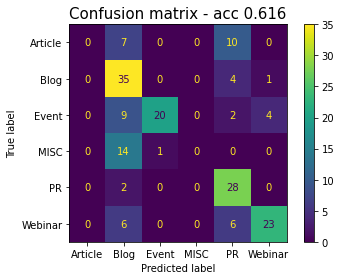


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.48      0.88      0.62        40
       Event       0.95      0.57      0.71        35
        MISC       0.00      0.00      0.00        15
          PR       0.56      0.93      0.70        30
     Webinar       0.82      0.66      0.73        35

    accuracy                           0.62       172
   macro avg       0.47      0.51      0.46       172
weighted avg       0.57      0.62      0.56       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf = fit_model(MultinomialNB(),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

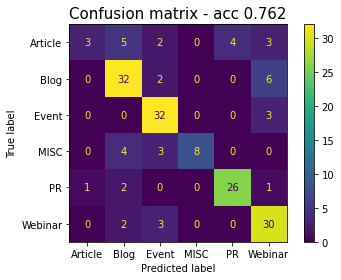


              precision    recall  f1-score   support

     Article       0.75      0.18      0.29        17
        Blog       0.71      0.80      0.75        40
       Event       0.76      0.91      0.83        35
        MISC       1.00      0.53      0.70        15
          PR       0.87      0.87      0.87        30
     Webinar       0.70      0.86      0.77        35

    accuracy                           0.76       172
   macro avg       0.80      0.69      0.70       172
weighted avg       0.77      0.76      0.74       172



In [ ]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

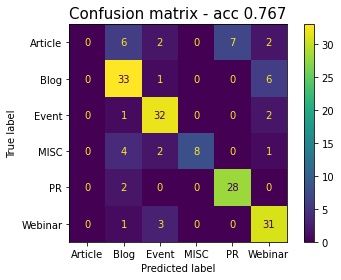


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.70      0.82      0.76        40
       Event       0.80      0.91      0.85        35
        MISC       1.00      0.53      0.70        15
          PR       0.80      0.93      0.86        30
     Webinar       0.74      0.89      0.81        35

    accuracy                           0.77       172
   macro avg       0.67      0.68      0.66       172
weighted avg       0.70      0.77      0.72       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced',
                                   ), 
                X_train_tr, 
                y_train,
                )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
clf = LogisticRegression(max_iter=3000, class_weight='balanced').fit(X_train_tr, y_train)
acc = clf.score(X_test_tr, y_test) 
acc

0.7906976744186046

In [ ]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced',
                                   ), 
                X_train_tr, 
                y_train,
                )

acc = clf.score(X_test_tr, y_test) 
acc



0.7906976744186046

In [ ]:
def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

def predict(clf, X_test):
  y_pred = clf.predict(X_test)
  return y_pred

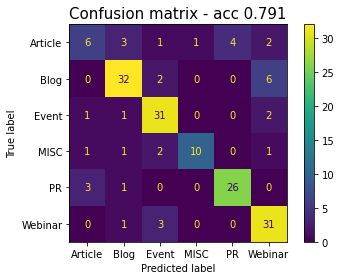


              precision    recall  f1-score   support

     Article       0.55      0.35      0.43        17
        Blog       0.82      0.80      0.81        40
       Event       0.79      0.89      0.84        35
        MISC       0.91      0.67      0.77        15
          PR       0.87      0.87      0.87        30
     Webinar       0.74      0.89      0.81        35

    accuracy                           0.79       172
   macro avg       0.78      0.74      0.75       172
weighted avg       0.79      0.79      0.78       172



In [ ]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced',
                                   ), 
                X_train_tr, 
                y_train,
                )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
X_train_tr.toarray().shape

(685, 16490)

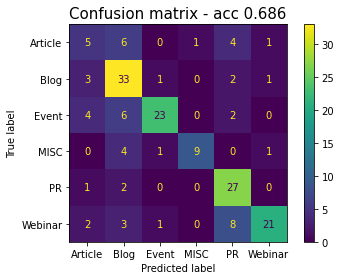


              precision    recall  f1-score   support

     Article       0.33      0.29      0.31        17
        Blog       0.61      0.82      0.70        40
       Event       0.88      0.66      0.75        35
        MISC       0.90      0.60      0.72        15
          PR       0.63      0.90      0.74        30
     Webinar       0.88      0.60      0.71        35

    accuracy                           0.69       172
   macro avg       0.71      0.65      0.66       172
weighted avg       0.72      0.69      0.68       172



In [ ]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
# print_important_features(clf, features=5)

In [ ]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,cleaned_lemmatized_text,y_true,y_pred
932,IQVIA IQV buy remain Q2 Solutions Stake Ups EP...,PR,Blog
821,reduce Clinical Trial Costs use decentralize c...,Blog,Article
713,CVS ink deal Medable enroll patient clinical t...,Article,PR
680,California end Verily covid19 testing partners...,Article,PR
880,Power Patient Centricity Rare Disease Studies ...,Blog,PR
904,introduce Medical Perspective Clinical Trial T...,Blog,PR
207,millennial really want work thing rest Us Do f...,Article,MISC
222,fully manage Magento Hosting JetRails fully ma...,MISC,Blog
631,advance Data Management Practices Intelligent ...,Webinar,PR
538,MedTech Digital Week Tuesday 9 March 2021 10 E...,Webinar,Article


In [ ]:
INDEX = 0
true_index = misclassified_df.index[INDEX]
misclassified_df.loc[true_index, 'cleaned_lemmatized_text']

'IQVIA IQV buy remain Q2 Solutions Stake Ups EPS View page authorize sponsor otherwise approve endorse company represent herein company logo represent herein trademark Microsoft Corporation Dow Jones Company Nasdaq Inc Forbes Media LLC Investor Business Daily Inc Morningstar Inc Copyright 2022 Zacks Investment Research 10 Riverside Plaza Suite # 1600 Chicago IL 60606 center everything strong commitment independent research share profitable discovery investor dedication give investor trading advantage lead creation prove Zacks Rank stock rating system since 1988 double SP 500 average gain +2451 per year return cover period January 1 1988 September 12 2022 Zacks Rank stock rating system return compute monthly base beginning month end month Zacks Rank stock price plus dividend receive particular month simple equally weight average return Zacks Rank stock calculate determine monthly return monthly return compound arrive annual return Zacks Rank stock include Zacks hypothetical portfolio be

# 2. DistilBERT approach (Ashwin N)

### Preprocessing

In [22]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [63]:
X_train, X_test, y_train, y_test = split_data(df_text, column=TEXT, test_size=0.2, val_size=None, random_state=0)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((685, 1), (172, 1), (685,), (172,))

In [65]:
def create_datasetdict(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, 
                       y_test: pd.Series, X_val: pd.DataFrame = None, y_val: pd.Series = None) -> DatasetDict:
  """
  Creates a DatasetDict object from pandas DataFrames and Series.
  
  Parameters:
  - X_train: pandas DataFrame containing the input data for the training set.
  - X_test: pandas DataFrame containing the input data for the test set.
  - y_train: pandas Series containing the target data for the training set.
  - y_test: pandas Series containing the target data for the test set.
  - X_val: (optional) pandas DataFrame containing the input data for the validation set.
  - y_val: (optional) pandas Series containing the target data for the validation set.
  
  Returns:
  - dataset: DatasetDict object containing the training, validation (optional) and test sets.
  """

  datasets = {
    'train': Dataset.from_dict(
        {TEXT: X_train[TEXT],
         TARGET: y_train,
         }
         ),
    'test': Dataset.from_dict(
        {TEXT: X_test[TEXT],
         TARGET: y_test,
         }
         )
    }
  
  if X_val is not None and y_val is not None:
    datasets['validation'] = Dataset.from_dict(
        {TEXT: X_val[TEXT],
         TARGET: y_val,
         }
         )

  dataset = DatasetDict(datasets)
  
  return dataset

In [66]:
dataset = create_datasetdict(X_train, X_test, y_train, y_test)

In [67]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 685
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 172
    })
})

In [68]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [69]:
def tokenize(batch):
    return tokenizer(batch[TEXT], padding=True, truncation=True)

In [70]:
dataset_encoded = dataset.map(
    tokenize, 
    batched=True, 
    batch_size=None,
    )

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [71]:
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [72]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch[TEXT], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    
    # Extract last hidden states
    outputs = tf_model(inputs)

     # Return vector for [CLS] token
    return {'hidden_state': outputs.last_hidden_state[:, 0].numpy()}

In [73]:
dataset_hidden = dataset_encoded.map(
    extract_hidden_states, 
    batched=True, 
    batch_size=16,
    )

  0%|          | 0/43 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [74]:
X_train_ = np.array(dataset_hidden['train']['hidden_state'])
# X_valid_ = np.array(dataset_hidden['validation']['hidden_state'])

y_train_ = np.array(dataset_hidden['train']['label'])
# y_valid_ = np.array(dataset_hidden['validation']['label'])

X_test_ = np.array(dataset_hidden['test']['hidden_state'])
y_test_ = np.array(dataset_hidden['test']['label'])

In [75]:
X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape

((685, 768), (172, 768), (685,), (172,))

In [ ]:
# X_train_valid_ = np.concatenate([X_train_, X_valid_])
# y_train_valid_ = np.concatenate([y_train_, y_valid_])

In [76]:
# X_train_valid_.shape, y_train_valid_.shape

In [ ]:
# X_valid_test_ = np.concatenate([X_valid_, X_test_])
# X_valid_.shape, X_test_.shape, X_valid_test_.shape

In [ ]:
# y_valid_test_ = np.concatenate([y_valid_, y_test_])
# y_valid_.shape, y_test_.shape, y_valid_test_.shape

### a) Modeling - ML approach:

In [77]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_test_, y_test_)

0.8023255813953488

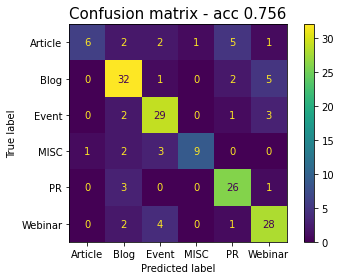


              precision    recall  f1-score   support

     Article       0.86      0.35      0.50        17
        Blog       0.74      0.80      0.77        40
       Event       0.74      0.83      0.78        35
        MISC       0.90      0.60      0.72        15
          PR       0.74      0.87      0.80        30
     Webinar       0.74      0.80      0.77        35

    accuracy                           0.76       172
   macro avg       0.79      0.71      0.72       172
weighted avg       0.77      0.76      0.75       172



In [78]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                          n_estimators=50,
                                          random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_pred = predict(rf_clf, X_test_)
y_probs = rf_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

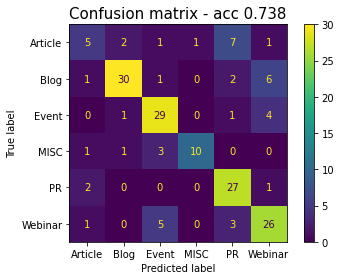


              precision    recall  f1-score   support

     Article       0.50      0.29      0.37        17
        Blog       0.88      0.75      0.81        40
       Event       0.74      0.83      0.78        35
        MISC       0.91      0.67      0.77        15
          PR       0.68      0.90      0.77        30
     Webinar       0.68      0.74      0.71        35

    accuracy                           0.74       172
   macro avg       0.73      0.70      0.70       172
weighted avg       0.74      0.74      0.73       172



In [79]:
svc_clf = fit_model(SVC(C=1,
                        class_weight='balanced',
                        ),
                    X_train_, 
                    y_train_,
                    )

y_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

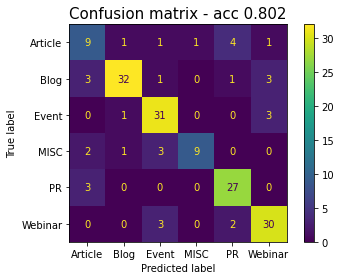


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [80]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                      class_weight='balanced', 
                                      ), 
                   X_train_, 
                   y_train_,
                   )

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

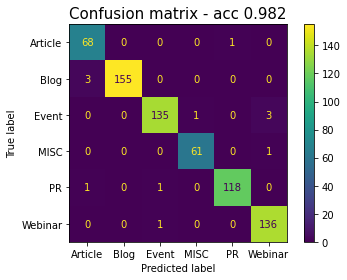


              precision    recall  f1-score   support

     Article       0.94      0.99      0.96        69
        Blog       1.00      0.98      0.99       158
       Event       0.99      0.97      0.98       139
        MISC       0.98      0.98      0.98        62
          PR       0.99      0.98      0.99       120
     Webinar       0.97      0.99      0.98       137

    accuracy                           0.98       685
   macro avg       0.98      0.98      0.98       685
weighted avg       0.98      0.98      0.98       685



In [81]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_)
print_confusion_matrix(y_train_, y_pred_train, with_report=True)

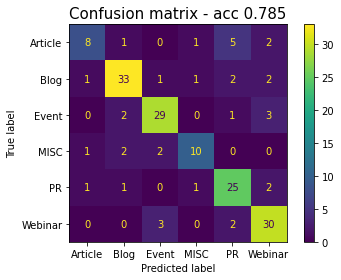


              precision    recall  f1-score   support

     Article       0.73      0.47      0.57        17
        Blog       0.85      0.82      0.84        40
       Event       0.83      0.83      0.83        35
        MISC       0.77      0.67      0.71        15
          PR       0.71      0.83      0.77        30
     Webinar       0.77      0.86      0.81        35

    accuracy                           0.78       172
   macro avg       0.78      0.75      0.75       172
weighted avg       0.79      0.78      0.78       172



In [82]:
lr_clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_, 
    y_train_,
    )

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

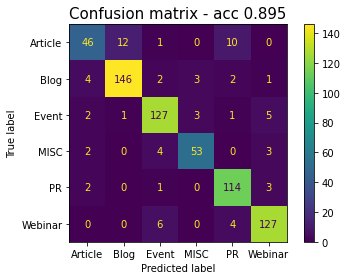


              precision    recall  f1-score   support

     Article       0.82      0.67      0.74        69
        Blog       0.92      0.92      0.92       158
       Event       0.90      0.91      0.91       139
        MISC       0.90      0.85      0.88        62
          PR       0.87      0.95      0.91       120
     Webinar       0.91      0.93      0.92       137

    accuracy                           0.89       685
   macro avg       0.89      0.87      0.88       685
weighted avg       0.89      0.89      0.89       685



In [83]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_)
print_confusion_matrix(y_train_, y_pred_train, with_report=True)

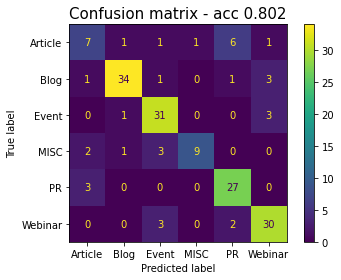


              precision    recall  f1-score   support

     Article       0.54      0.41      0.47        17
        Blog       0.92      0.85      0.88        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.75      0.90      0.82        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.75      0.76       172
weighted avg       0.80      0.80      0.80       172



In [84]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [ ]:
# lr_clf = fit_model(LogisticRegression(
#     max_iter=3000, 
#     class_weight='balanced',
#     solver='saga', # default: 'lbfgs' 
#     penalty='elasticnet', # default: 'l2',
#     l1_ratio=0.9, # only relevant when penalty='elasticnet'
#     ), 
#                 X_train_, 
#                 y_train_)

# y_pred = predict(lr_clf, X_valid_test_)
# y_probs = lr_clf.predict_proba(X_valid_test_)

# print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

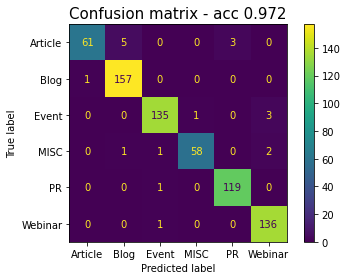


              precision    recall  f1-score   support

     Article       0.98      0.88      0.93        69
        Blog       0.96      0.99      0.98       158
       Event       0.98      0.97      0.97       139
        MISC       0.98      0.94      0.96        62
          PR       0.98      0.99      0.98       120
     Webinar       0.96      0.99      0.98       137

    accuracy                           0.97       685
   macro avg       0.97      0.96      0.97       685
weighted avg       0.97      0.97      0.97       685



In [ ]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

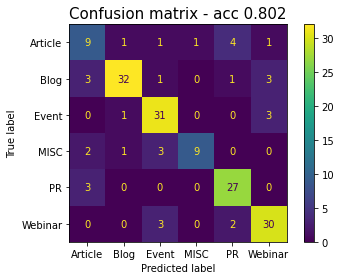


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [ ]:
pickle.dump(lr_clf, open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'wb'))

In [ ]:
# lr_clf = pickle.load(open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'rb'))

In [ ]:
df_text

,text,label,url,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,2,NaN,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,5,NaN,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",5,NaN,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,1,NaN,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,0,NaN,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,0,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,0,http://www.outsourcing-pharma.com/Article/2021...,digital transformation of clinical research ac...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,0,http://www.entrepreneur.com/article/400416,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,0,http://www.koreabiomed.com/news/articleView.ht...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...


In [ ]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [ ]:
mask = y_pred != y_test_

In [ ]:
X_test = pd.DataFrame(X_test, columns=['text']) # transform into DataFrame

misclassified_df = create_misclassified_df(X_test=X_test, y_test=y_test, y_pred=y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df.head()

,text,y_true,y_pred
932,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,Article
713,CVS inks a deal with Medable to enroll more pa...,Article,Webinar
680,California ends Verily COVID-19 testing partne...,Article,PR
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article
791,Overview of EMA's latest IDMP Updates in 2022....,Blog,Webinar


In [ ]:
# X_valid_test = np.concatenate([X_val, X_test]) # concatenate
# X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

In [ ]:
misclassified_df.shape

(34, 3)

In [ ]:
df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
df_merged.index = misclassified_df.index
df_merged

,text,y_true,y_pred,url
932,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,Article,http://www.zacks.com/stock/news/1348735/iqvia-...
713,CVS inks a deal with Medable to enroll more pa...,Article,Webinar,http://www.statnews.com/2022/02/08/cvs-medable...
680,California ends Verily COVID-19 testing partne...,Article,PR,http://www.beckershospitalreview.com/healthcar...
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article,NaN
791,Overview of EMA's latest IDMP Updates in 2022....,Blog,Webinar,http://www.calyx.ai/journal/overview-ema-lates...
880,The Power of Patient-Centricity in Rare Diseas...,Blog,Webinar,http://medrio.com/resource/the-power-of-patien...
904,Introducing a Medical Perspective on Clinical ...,Blog,PR,http://www.calyx.ai/journal/a-medical-perspect...
524,New Data on the Future of CNS Clinical Trials....,Webinar,Event,http://science37.com/Company/Events/webinar-ne...
207,What Do Millennials Really Want at Work? The S...,Article,MISC,NaN
222,Fully Managed Magento Hosting — JetRails. Full...,MISC,Event,NaN


In [ ]:
df_merged.shape

(34, 4)

In [ ]:
df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences.head()

,y_true,y_pred
932,4,0
713,0,3
680,0,4
84,1,0
791,1,3


In [ ]:
df_confidences.shape

(34, 2)

In [ ]:
mask = y_pred != y_test

In [ ]:
# mask = y_pred != y_valid_test_ and y_valid_test_ != 5

In [ ]:
# num_misc = (df_confidences['y_true'] == 5).sum()
# num_misc

In [ ]:
confidence_pred = y_probs[mask, df_confidences['y_pred']]
confidence_pred

array([0.47852343, 0.65779459, 0.76266637, 0.52429177, 0.57569192,
       0.45889863, 0.44239946, 0.52224769, 0.83887097, 0.35747723,
       0.53192366, 0.44348663, 0.74126559, 0.74942645, 0.75143545,
       0.58862598, 0.94488167, 0.57746427, 0.63949315, 0.4560506 ,
       0.74984187, 0.81554   , 0.61604311, 0.80690224, 0.69743319,
       0.47026566, 0.45883194, 0.48844072, 0.65657218, 0.58439351,
       0.55748788, 0.64155521, 0.72504326, 0.52251202])

In [ ]:
confidence_true = y_probs[mask, df_confidences['y_true']]
confidence_true

array([1.06330982e-02, 4.54263046e-03, 2.22608013e-01, 2.14130355e-01,
       3.98678983e-02, 3.44417994e-01, 1.44923409e-01, 3.26513112e-01,
       8.50907755e-03, 2.97718536e-01, 2.65714554e-01, 2.19222882e-02,
       2.58530860e-03, 1.49308210e-01, 1.86888861e-01, 4.07322569e-01,
       3.73701648e-02, 4.54404803e-02, 3.71951038e-02, 4.54936333e-01,
       5.91491198e-02, 1.79204692e-01, 2.29012076e-01, 1.09156224e-01,
       2.80255528e-01, 1.49794599e-01, 3.55854160e-01, 1.67886807e-01,
       1.83898898e-01, 3.95439028e-01, 4.18313024e-01, 2.08382098e-04,
       2.51553251e-01, 3.69709096e-01])

In [ ]:
# confidence_true = y_probs[:-num_misc][mask[:-num_misc], df_confidences['y_true'][:-num_misc]]
# confidence_true = np.concatenate((confidence_true, np.zeros(num_misc)), axis=0)
# confidence_true

In [ ]:
df_merged['conf_true'] = confidence_true.round(2)
df_merged['conf_pred'] = confidence_pred.round(2)

In [ ]:
df_merged.tail()

,text,y_true,y_pred,url,conf_true,conf_pred
61,Artificial Intelligence Is Here - People Just ...,Blog,Article,NaN,0.40,0.58
3,FAQs for some new features available in the Be...,Blog,Article,NaN,0.42,0.56
206,How to Do Walking Meetings Right. New! HBR Le...,Article,Event,NaN,0.00,0.64
121,font-display | CSS-Tricks. The font-display pr...,MISC,Article,NaN,0.25,0.73
299,In Conduct of Decentralized Trials. In today’s...,Event,Webinar,http://app.swapcard.com/event/scdm-2021-annual...,0.37,0.52


In [ ]:
df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]

In [ ]:
df_merged.shape

(34, 6)

In [ ]:
# df = df_merged.iloc[13:, :]

In [ ]:
# df.drop('text', axis=1).head(3)

In [ ]:
misclassified = df_merged.shape[0]
misclassified_truncated = (df_merged[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT).sum()
print(f'Out of the {misclassified} misclassified samples, {misclassified_truncated}'
      f' ({misclassified_truncated / misclassified:.0%} of the total) were truncated.')

Out of the 34 misclassified samples, 11 (32% of the total) were truncated.


In [ ]:
save_variables({'df_merged': df_merged})

In [ ]:
misclassified_urls = df_merged['url'].tolist()
misclassified_urls

['http://www.zacks.com/stock/news/1348735/iqvia-iqv-buys-remaining-q2-solutions-stake-ups-eps-view?cid=CS-ZC-FT-analyst_blog%7Ccompany_news_-_corporate_actions-1348735',
 'http://www.statnews.com/2022/02/08/cvs-medable-clinical-trials/',
 'http://www.beckershospitalreview.com/healthcare-information-technology/california-ends-verily-covid-19-testing-partnership.html',
 nan,
 'http://www.calyx.ai/journal/overview-ema-latest-idmp-updates/',
 'http://medrio.com/resource/the-power-of-patient-centricity-in-rare-disease-studies/',
 'http://www.calyx.ai/journal/a-medical-perspective-on-clinical-trial-technology/',
 'http://science37.com/Company/Events/webinar-new-data-future-cns-clinical-trials',
 nan,
 nan,
 'http://pages.questexinfo.com/glookowbnr12082021/?pk=Glooko',
 'http://www.zacks.com/stock/news/1754370/iqvia-iqv-announces-launch-of-clinical-data-analytics-suite?cid=CS-ZC-FT-analyst_blog%7Ccompany_news_-_corporate_actions-1754370',
 'http://www.calyx.ai/journal/ctms-unlocking-clinical-

In [ ]:
wrong_conf_pred = np.max(y_probs[mask], axis=1)
wrong_conf_pred[:3]

array([0.47852343, 0.65779459, 0.76266637])

In [ ]:
right_conf_pred = np.max(y_probs[~mask], axis=1)
right_conf_pred[:3]

array([0.91784542, 0.51219777, 0.98621136])

In [ ]:
assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [ ]:
# Comparison between using 'l1' vs 'l2' regularization (without class Article, with Home Page):
# Acc test set - 'l1': 0.812, 'l2': 0.808
# Acc train set - 'l1': 0.898, 'l2': 0.983
# Average confidence of misclassified samples - 'l1': 0.5134, 'l2': 0.6213
# Average confidence of correctly classified samples - 'l1': 0.6977, 'l2': 0.8412
# Median confidence of misclassified samples - 'l1': 0.4976, 'l2': 0.5665
# Median confidence of correctly classified samples - 'l1': 0.7224, 'l2': 0.8995

In [ ]:
# Comparison between using 'l1' vs 'l2' regularization (with class Article, without Home Page):
# Acc test set - 'l1': 0.717, 'l2': 0.759
# Acc train set - 'l1': 0.886, 'l2': 0.988
# Average confidence of misclassified samples - 'l1': 0.581, 'l2': 0.600
# Average confidence of correctly classified samples - 'l1': 0.671, 'l2': 0.660
# Median confidence of misclassified samples - 'l1': 0.564, 'l2': 0.5813
# Median confidence of correctly classified samples - 'l1': 0.698, 'l2': 0.6841

In [ ]:
sns.set_theme()

In [ ]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.5865, Mean: 0.6128.
Confidence of correctly classified samples 	- Median: 0.8802, Mean: 0.8285.


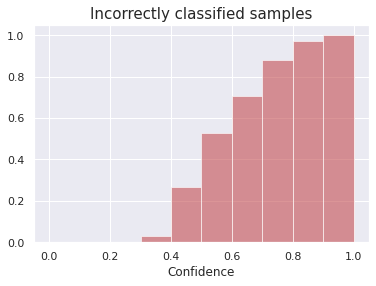

In [ ]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

In [ ]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
# plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

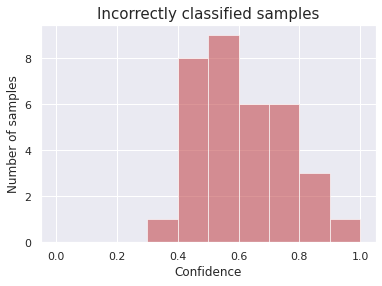

In [ ]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

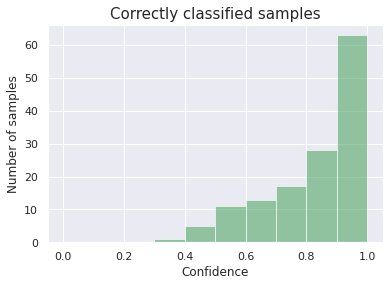

In [ ]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# # misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

### b) Modeling - DL approach:

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# The column names to convert to TensorFlow tensors
# from transformers import DataCollatorForTokenClassification
# from transformers import DefaultDataCollator

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors='tf')
# data_collator = DefaultDataCollator(return_tensors='tf')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

tf_train_dataset = dataset_encoded['train'].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=['label'], 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_eval_dataset = dataset_encoded['validation'].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=['label'], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

In [ ]:
num_labels = len(y_train.value_counts())

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.1
 
# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT, 
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
    num_labels=num_labels,
    )
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
# tf_model = TFDistilBertModel.from_pretrained(
#     'distilbert-base-uncased', 
#     config=config
#     )

# # # Make tf_model layers untrainable
# for layer in tf_model.layers:
#     layer.trainable = False

In [ ]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    # num_labels=num_labels,
    )
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_38', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# With:
# DISTILBERT_DROPOUT = 0.2
# DISTILBERT_ATT_DROPOUT = 0.1

epochs = 1000
patience = 5

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

history = tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset, 
    epochs=epochs,
    callbacks=[callback]
    )

Epoch 1/1000
38/38 [==============================] - 48s 1s/step - loss: 1.7609 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.4767
Epoch 2/1000
38/38 [==============================] - 37s 979ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.5893 - val_loss: 1.5302 - val_sparse_categorical_accuracy: 0.7093
Epoch 3/1000
38/38 [==============================] - 37s 980ms/step - loss: 1.4147 - sparse_categorical_accuracy: 0.6878 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/1000
38/38 [==============================] - 37s 987ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1303 - val_sparse_categorical_accuracy: 0.7093
Epoch 5/1000
38/38 [==============================] - 37s 982ms/step - loss: 1.0323 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.7209
Epoch 6/1000
38/38 [==============================] - 38s 988ms/step - loss: 0.8964 - sp

In [ ]:
# tf.keras.models.save_model(
#     tf_model, 
#     filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89', 
#     overwrite=True, 
#     save_format='tf'
#     )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_val0.87_test0.8')

In [ ]:
# ! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [ ]:
# tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
from tensorflow.keras.models import load_model
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/url_classification/my_model_val0.81_test0.85')

In [ ]:
tf_model

In [ ]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89') 
# # why doesn't it work when running the next cell with the loaded model?

OSError: ignored

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [ ]:
# loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
# print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

In [ ]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

38/38 [==============================] - 12s 316ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9750
Loss: 0.15307635068893433	 Train Accuracy: 0.9749582409858704


In [ ]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

6/6 [==============================] - 2s 285ms/step - loss: 0.6126 - sparse_categorical_accuracy: 0.8256
Loss: 0.6125950813293457	 Eval Accuracy: 0.8255813717842102


In [ ]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

11/11 [==============================] - 4s 325ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.8372
Loss: 0.5770680904388428	 Test Accuracy: 0.8372092843055725


In [ ]:
output_logits = tf_model.predict(tf_test_dataset).logits
y_pred = np.argmax(output_logits, axis=-1)

11/11 [==============================] - 5s 321ms/step


In [ ]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [ ]:
y_probs = tf.nn.softmax(output_logits)
y_probs[:3]

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0.08416542, 0.878566  , 0.00733409, 0.01031895, 0.00701632,
        0.01259932],
       [0.7317688 , 0.05313385, 0.0171092 , 0.01492369, 0.12416278,
        0.05890167],
       [0.08567395, 0.85064834, 0.01047275, 0.03116656, 0.0085467 ,
        0.01349174]], dtype=float32)>

In [ ]:
sns.set_theme(style='white')

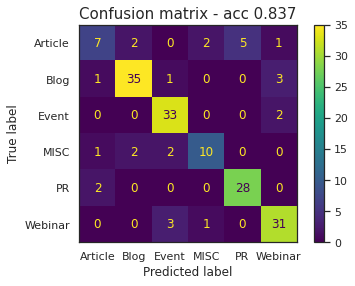


              precision    recall  f1-score   support

     Article       0.64      0.41      0.50        17
        Blog       0.90      0.88      0.89        40
       Event       0.85      0.94      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.85      0.93      0.89        30
     Webinar       0.84      0.89      0.86        35

    accuracy                           0.84       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.83      0.84      0.83       172



In [ ]:
print_confusion_matrix(y_test, y_pred, with_report=True)

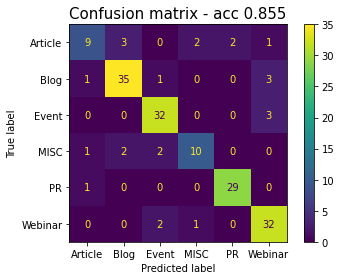


              precision    recall  f1-score   support

     Article       0.75      0.53      0.62        17
        Blog       0.88      0.88      0.88        40
       Event       0.86      0.91      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.94      0.97      0.95        30
     Webinar       0.82      0.91      0.86        35

    accuracy                           0.85       172
   macro avg       0.84      0.81      0.82       172
weighted avg       0.85      0.85      0.85       172



In [ ]:
print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [ ]:
y_test

831    1
932    4
821    1
843    1
642    3
      ..
404    2
405    2
563    3
909    1
580    3
Name: label, Length: 172, dtype: int64

In [ ]:
mask = y_pred != y_test
mask

831    False
932     True
821    False
843    False
642    False
       ...  
404    False
405    False
563    False
909    False
580    False
Name: label, Length: 172, dtype: bool

In [ ]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [ ]:
np.array(y_test)

array([1, 4, 1, 1, 3, 0, 0, 4, 2, 4, 1, 1, 1, 0, 3, 1, 4, 3, 3, 2, 3, 4,
       4, 0, 2, 2, 5, 3, 3, 4, 1, 3, 5, 2, 1, 1, 1, 1, 4, 1, 4, 1, 3, 2,
       1, 0, 2, 0, 3, 2, 3, 1, 0, 3, 1, 4, 3, 4, 2, 3, 5, 0, 1, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 5, 0, 1, 1, 4, 0, 1,
       1, 4, 3, 5, 1, 0, 4, 1, 4, 4, 3, 3, 3, 5, 1, 3, 5, 4, 5, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 0, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 5, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 0, 0,
       5, 4, 3, 2, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [ ]:
len(y_test), len(y_pred)

(172, 172)

In [ ]:
misclassified_df_nn = pd.DataFrame(
    {'y_true': y_test[mask].reset_index(drop=True).replace(labels_decoded),
     'y_pred': pd.Series(y_pred[mask]).replace(labels_decoded),
     }).set_index(y_test[mask].index)
misclassified_df_nn

,y_true,y_pred
932,PR,Article
713,Article,MISC
680,Article,PR
791,Blog,Webinar
904,Blog,Webinar
524,Webinar,Event
207,Article,MISC
538,Webinar,Event
951,PR,Article
842,Blog,Webinar


In [ ]:
# I can merge with url/text using the index of y_test, do it later.

In [ ]:
df_confidences_nn = misclassified_df_nn[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences_nn.head()

,y_true,y_pred
932,4,0
713,0,5
680,0,4
791,1,3
904,1,3


In [ ]:
y_probs_array = np.array(y_probs)

In [ ]:
confidence_pred_nn = y_probs_array[mask, df_confidences_nn['y_pred']]
confidence_pred_nn

array([0.7317688 , 0.6880048 , 0.87609005, 0.8604847 , 0.9083877 ,
       0.6410547 , 0.81165284, 0.9317813 , 0.47587645, 0.9376277 ,
       0.61182654, 0.84027946, 0.8377481 , 0.8389856 , 0.851417  ,
       0.9430426 , 0.9203028 , 0.54665744, 0.9204443 , 0.8084895 ,
       0.9474942 , 0.32922313, 0.8855198 , 0.694019  , 0.7159665 ,
       0.85666305, 0.73370403, 0.9439738 ], dtype=float32)

In [ ]:
confidence_true_nn = y_probs_array[mask, df_confidences_nn['y_true']]
confidence_true_nn

array([0.12416278, 0.06829616, 0.0711691 , 0.02685313, 0.02636965,
       0.26135868, 0.0567484 , 0.02559043, 0.4171192 , 0.01154234,
       0.32100692, 0.04748523, 0.11640108, 0.10977008, 0.0378789 ,
       0.01535015, 0.04170987, 0.31138265, 0.02573165, 0.14057119,
       0.0131673 , 0.25806272, 0.01883534, 0.22927858, 0.06642533,
       0.00938151, 0.05739936, 0.0123579 ], dtype=float32)

In [ ]:
misclassified_df_nn['conf_true'] = confidence_true_nn.round(2)
misclassified_df_nn['conf_pred'] = confidence_pred_nn.round(2)
misclassified_df_nn.head()

,y_true,y_pred,conf_true,conf_pred
932,PR,Article,0.12,0.73
713,Article,MISC,0.07,0.69
680,Article,PR,0.07,0.88
791,Blog,Webinar,0.03,0.86
904,Blog,Webinar,0.03,0.91


In [ ]:
misclassified_df_nn = misclassified_df_nn[['y_true', 'conf_true', 'y_pred', 'conf_pred']]
misclassified_df_nn

,y_true,conf_true,y_pred,conf_pred
932,PR,0.12,Article,0.73
713,Article,0.07,MISC,0.69
680,Article,0.07,PR,0.88
791,Blog,0.03,Webinar,0.86
904,Blog,0.03,Webinar,0.91
524,Webinar,0.26,Event,0.64
207,Article,0.06,MISC,0.81
538,Webinar,0.03,Event,0.93
951,PR,0.42,Article,0.48
842,Blog,0.01,Webinar,0.94


In [ ]:
save_variable(misclassified_df_nn, 'df_merged_nn')

In [ ]:
wrong_conf_pred = np.max(y_probs_array[mask], axis=1)
wrong_conf_pred[:3]

array([0.7317688 , 0.6880048 , 0.87609005], dtype=float32)

In [ ]:
right_conf_pred = np.max(y_probs_array[~mask], axis=1)
right_conf_pred[:3]

array([0.878566  , 0.85064834, 0.9120738 ], dtype=float32)

In [ ]:
assert y_probs_array.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [ ]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.8021, Mean: 0.7702.
Confidence of correctly classified samples 	- Median: 0.9231, Mean: 0.8750.


In [ ]:
sns.set_theme()

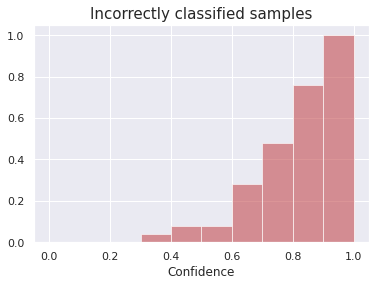

In [ ]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

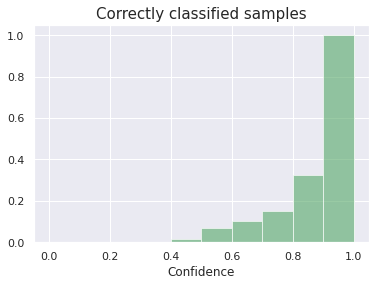

In [ ]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

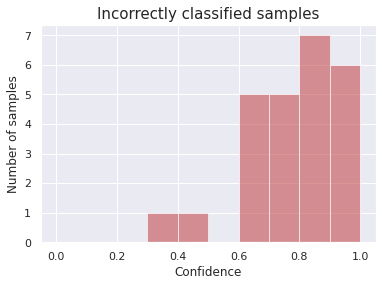

In [ ]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

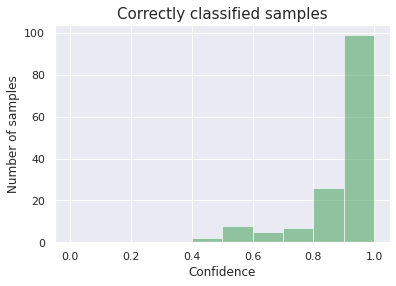

In [ ]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_test, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()